
## Installs & import

In [1]:
!pip install fancy_einsum einops tqdm torchtyping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1


In [2]:

import random
import re
from dataclasses import dataclass

import numpy as np
import torch as t
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import einops
from fancy_einsum import einsum
from torchtyping import TensorType
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = t.device("cuda" if t.cuda.is_available() else "cpu")

## Modules & Transformer

In [47]:
# From previous exercises

class PositionalEncoding(nn.Module):
    pe: t.Tensor

    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        self.d_model = d_model
        self.max_len = max_len
        self.dropout = dropout
        
        super().__init__()

        self.register_buffer(
            "pe",    
            self.encode(self.max_len, self.d_model)
        )

    def encode(self, seq_len: int, embedding_dim: int) -> t.Tensor:
        raise NotImplementedError

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: Tensor, shape [batch, seq_len, embedding_dim]
        '''

        _, seq_len, embedding_dim = x.shape

        return x + self.pe[:seq_len, :embedding_dim].unsqueeze(0)


class SinusoidalPositionalEncoding(PositionalEncoding):
    def encode(self, seq_len: int, embedding_dim: int) -> t.Tensor:
        i = t.arange(seq_len).unsqueeze(1)
        d = t.arange(embedding_dim).unsqueeze(0)

        return (
            t.sin(i / 10000 ** (d / embedding_dim)) * (d % 2 == 0)
            + t.cos(i / 10000 ** ((d - 1) / embedding_dim)) * (d % 2 == 1)
        )

def mask(A: TensorType[..., "seq_len", "seq_len"]) -> TensorType[..., "seq_len", "seq_len"]:
    seq_len = A.shape[-1]

    mask = t.triu(t.ones(seq_len, seq_len), diagonal=1).bool().to(device)
    return A.masked_fill(mask, -np.inf)

def multihead_masked_attention(
    Q: TensorType["batch", "seq", "n_heads*headsize"], 
    K: TensorType["batch", "seq", "n_heads*headsize"], 
    V: TensorType["batch", "seq", "n_heads*headsize"],
    num_heads: int
) -> TensorType["batch", "seq", "n_heads*headsize"]:
    '''
    Should return the results of multihead self-attention.

    Q: shape (batch, seq, n_heads*headsize)
    K: shape (batch, seq, n_heads*headsize)
    V: shape (batch, seq, n_heads*headsize)
    num_heads: int

    Return: shape (batch, seq, n_heads*headsize)
    '''
    _Q = einops.rearrange(Q, "b s (n h) -> b n s h", n=num_heads)    
    _K = einops.rearrange(K, "b s (n h) -> b n s h", n=num_heads)    
    _V = einops.rearrange(V, "b s (n h) -> b n s h", n=num_heads)

    d_head = _Q.shape[-1]

    A_pre: TensorType["b", "n", "s_q", "s_k"] = mask(
        einsum("b n s_q h, b n s_k h -> b n s_q s_k", _Q, _K)
    ) / np.sqrt(d_head)

    A: TensorType["b", "n", "s_q", "s_k"] = t.softmax(A_pre, dim=-1)
    AV: TensorType["b", "n", "s_q", "h"] = einsum("b n s_q s_k, b n s_k h -> b n s_q h", A, _V)

    return einops.rearrange(AV, "b n s h -> b s (n h)") 


class MultiheadMaskedAttention(nn.Module):
    W_QKV: nn.Linear
    W_O: nn.Linear

    def __init__(self, hidden_size: int, num_heads: int):
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads

        super().__init__()

        self.W_QKV = nn.Linear(hidden_size, hidden_size * 3)
        self.W_O = nn.Linear(hidden_size, hidden_size)

    def forward(self, x: TensorType["batch", "seq", "hidden_size"]) -> TensorType["batch", "seq", "hidden_size"]:
        '''
        x: shape (batch, seq, hidden_size)

        Return: shape (batch, seq, hidden_size)
        '''
        Q, K, V = self.W_QKV(x).chunk(3, dim=-1)        
        return self.W_O(multihead_masked_attention(Q, K, V, self.num_heads))


@dataclass(frozen=True)
class TransformerConfig:
    '''Constants used throughout your decoder-only transformer model.'''

    num_layers: int = 6
    num_heads: int = 8
    vocab_size: int = 256
    hidden_size: int = 512
    max_seq_len: int = 512
    dropout: float = 0.1
    layer_norm_epsilon: float = 1e-05

config = TransformerConfig()

class MLPBlock(nn.Module):

    def __init__(self, hidden_size: int, dropout: float):
        self.hidden_size = hidden_size

        super().__init__()

        self.linear1 = nn.Linear(hidden_size, hidden_size * 4)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(hidden_size * 4, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: t.Tensor) -> t.Tensor:
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.linear2(x)
        x = self.dropout(x)

        return x

class DecoderBlock(nn.Module):

    def __init__(self, hidden_size: int, num_heads: int, layer_norm_epsilon: float, dropout: float):
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.layer_norm_epsilon = layer_norm_epsilon
        self.dropout = dropout

        super().__init__()

        self.attention = MultiheadMaskedAttention(hidden_size, num_heads)
        self.ln1 = nn.LayerNorm(hidden_size, eps=layer_norm_epsilon)
        self.mlp = MLPBlock(hidden_size, dropout)
        self.ln2 = nn.LayerNorm(hidden_size, eps=layer_norm_epsilon)

    def forward(self, x: t.Tensor) -> t.Tensor:
        x = x + self.attention(self.ln1(x))
        x = x + self.mlp(self.ln2(x))

        return x


class DecoderOnlyTransformer(nn.Module):

    def __init__(self, config: TransformerConfig):
        self.config = config

        super().__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.hidden_size)
        self.positional_embedding = SinusoidalPositionalEncoding(config.hidden_size, config.max_seq_len)

        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(config.hidden_size, config.num_heads, config.layer_norm_epsilon, config.dropout)
            for _ in range(config.num_layers)
        ])
        self.ln = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)
        self.unembed = nn.Linear(config.hidden_size, config.vocab_size)        

    def forward(self, x: t.Tensor) -> t.Tensor:
        x = self.embedding(x)
        x = self.positional_embedding(x)
        x = self.dropout(x)

        for decoder_block in self.decoder_blocks:
            x = decoder_block(x)
        
        x = self.ln(x)
        x = self.unembed(x)

        return x


# %%


## Tokenizer

In [48]:

from typing import Optional, Union


with open("./shakespeare.txt", "r") as f:
    shakespeare = f.read()

class WordsTokenizer():
    def __init__(self, corpus: str):
        self.from_tokens = list(set(re.split(r"\b", corpus)))
        self.to_tokens = {k: i for i, k in enumerate(self.from_tokens)}
        self.vocab_size = len(self.from_tokens)

    def encode(self, initial_text: str, return_tensors: Optional[str] = None) -> Union[list, np.ndarray, t.Tensor]:
        tensors_list = [self.to_tokens[s] for s in re.split(r"\b", initial_text) if len(s) > 0]
        if return_tensors is None:
            return tensors_list
        elif return_tensors == "pt":
            return t.tensor(tensors_list)
        elif return_tensors == "np":
            return np.array(tensors_list)
        else:
            raise Exception("Unexpected value for `return_tensors`.")

    def decode(self, list_of_ids: Union[t.Tensor, list]) -> str:
        return ''.join([self.from_tokens[token] for token in list_of_ids])

tokenizer = WordsTokenizer(shakespeare)
shakespeare_encoded = tokenizer.encode(shakespeare, return_tensors="pt").to(device)
print(tokenizer.from_tokens[:10], len(tokenizer.from_tokens),)
print("# of tokens in corpus:", len(shakespeare_encoded))

['Prov', 'Fooles', 'duchies', 'willingly', 'quotidian', 'established', 'Advantage', '?\n\n                       ', 'Dolphin', 'Cotsole'] 34543
# of tokens in corpus: 1987757


## Dataset

In [49]:

class ShakespeareDataset(Dataset):
    def __init__(self, tokens: Union[t.Tensor, list], seq_len: int):
        self.inputs = []
        self.targets = []

        for i in range(0, len(tokens) - seq_len - 1, seq_len):
            self.inputs.append(tokens[i : i + seq_len])
            self.targets.append(tokens[i + 1 : i + seq_len + 1])

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx: int):
        input_ = self.inputs[idx]
        target = self.targets[idx]
        return input_, target

train_corpus = shakespeare_encoded[:int(len(shakespeare_encoded) * 0.8)]
test_corpus = shakespeare_encoded[int(len(shakespeare_encoded) * 0.8) :]

seq_len = 48

train_data = ShakespeareDataset(train_corpus, seq_len) # type: ignore
test_data = ShakespeareDataset(test_corpus, seq_len) # type: ignore

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

print("# samples in train_data:", len(train_data))
print("# samples in test_data:", len(test_data))

# samples in train_data: 33129
# samples in test_data: 8282


## Transformer settings

In [50]:
config = TransformerConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=512,
    num_layers=8,
    num_heads=8,
    max_seq_len=48
)

transformer = DecoderOnlyTransformer(config)
transformer.to(device)

DecoderOnlyTransformer(
  (embedding): Embedding(34543, 512)
  (positional_embedding): SinusoidalPositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (decoder_blocks): ModuleList(
    (0): DecoderBlock(
      (attention): MultiheadMaskedAttention(
        (W_QKV): Linear(in_features=512, out_features=1536, bias=True)
        (W_O): Linear(in_features=512, out_features=512, bias=True)
      )
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLPBlock(
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (gelu): GELU(approximate=none)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (1): DecoderBlock(
      (attention): MultiheadMaskedAttention(
        (W_QKV): Linear(in_features=512, out_features=1536, bias=True)
        (W_O): Linear(in_features=512, out_featu

## Train

In [51]:

def train(model, optimizer, loss_fn, trainloader, epochs, dataset_name=None, plot=True):

    loss_list = []

    for epoch in range(epochs):
        
        progress_bar = tqdm(trainloader)
        
        for (x, y) in progress_bar:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            
            logits = model(x)
            # logits dimensions are (batch, seq, digits), but we care about probabilities for each digit
            # so we need to reshape into (batch * seq, digits)
            loss = loss_fn(einops.rearrange(logits, "b s d -> (b s) d"), y.flatten())
            loss.backward()

            optimizer.step()
            
            progress_bar.set_description(f"epoch = {epoch+1}, loss = {loss.item():.4f}")

            loss_list.append(loss.item())
    
        if plot:
            plt.plot(loss_list)
            plt.title(f"{dataset_name} loss")
            plt.show()
    
    return model    

  0%|          | 0/1036 [00:00<?, ?it/s]

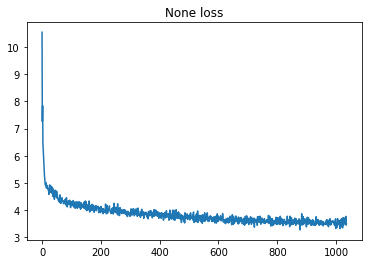

DecoderOnlyTransformer(
  (embedding): Embedding(34543, 512)
  (positional_embedding): SinusoidalPositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (decoder_blocks): ModuleList(
    (0): DecoderBlock(
      (attention): MultiheadMaskedAttention(
        (W_QKV): Linear(in_features=512, out_features=1536, bias=True)
        (W_O): Linear(in_features=512, out_features=512, bias=True)
      )
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLPBlock(
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (gelu): GELU(approximate=none)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (1): DecoderBlock(
      (attention): MultiheadMaskedAttention(
        (W_QKV): Linear(in_features=512, out_features=1536, bias=True)
        (W_O): Linear(in_features=512, out_featu

In [52]:
optimizer = t.optim.Adam(transformer.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train(transformer, optimizer, loss_fn, train_dataloader, epochs=1)

## Sampling

In [54]:

import torch as t
import torch.nn.functional as F
from torchtyping import TensorType

def greedy_search(logits: t.Tensor) -> int:
    '''
    logits: shape (vocab_size, )

    Return: the most likely token (as an integer)
    '''
    item = logits.argmax().item()
    assert isinstance(item, int)
    return item

def sample_basic(logits: t.Tensor) -> int:
    '''
    logits: shape (vocab_size, ) - unnormalized log-probabilities

    Return: a sampled token
    '''
    item = t.distributions.categorical.Categorical(logits=logits).sample().item()
    assert isinstance(item, int)
    return item

def apply_temperature(logits: t.Tensor, temperature: float) -> t.Tensor:
    '''
    logits: shape (vocab_size, )

    Return: shape (vocab_size, )
    '''
    assert temperature > 0
    return logits / temperature

def apply_freq_penalty(input_ids: t.Tensor, logits: t.Tensor, freq_penalty: float) -> t.Tensor:
    '''
    input_ids: shape (seq, )
    logits: shape (vocab_size, )

    Return: shape (vocab_size, )
    '''
    id_counts = t.bincount(input_ids.reshape((-1,)), minlength=logits.shape[0])
    return logits - freq_penalty * id_counts
    
def sample_top_k(logits: t.Tensor, top_k: int) -> int:
    '''
    logits: shape (vocab_size, ) - unnormalized log-probabilities
    top_k: only consider this many of the most likely tokens for sampling

    Return: a sampled token
    '''
    assert top_k > 0
    _top_k_logits, top_k_indices = logits.topk(top_k)

    top_k_logits = t.ones_like(logits) * float("-inf")
    top_k_logits[top_k_indices] = _top_k_logits

    return sample_basic(top_k_logits)


def sample_top_p(logits: t.Tensor, top_p: float, min_tokens_to_keep: int = 1) -> int:
    '''
    logits: shape (vocab_size, ) - unnormalized log-probabilities

    Return: a sampled token
    '''
    assert top_p > 0
    assert min_tokens_to_keep > 0

    sorted_logits, sorted_indices = logits.sort(descending=True)
    cumulative_probs = F.softmax(sorted_logits, dim=0).cumsum(dim=0)

    reject_index = min(t.searchsorted(cumulative_probs, top_p) + 1, len(sorted_indices))
    top_p_indices = sorted_indices[:reject_index]

    top_p_logits = t.ones_like(logits) * float("-inf")
    top_p_logits[top_p_indices] = logits[top_p_indices]

    return sample_basic(top_p_logits)
    

def apply_sampling_methods(
    input_ids: t.Tensor, logits: t.Tensor, temperature=1.0, freq_penalty=0.0, top_k=0, top_p=0.0
) -> int:
    '''
    Return the next token, sampled from the model's probability distribution with modifiers.
x
    input_ids: shape (seq,)
    '''
    assert input_ids.ndim == 1, "input_ids should be a 1D sequence of token ids"
    assert temperature >= 0, "Temperature should be non-negative"
    assert 0 <= top_p <= 1.0, "Top-p must be a probability"
    assert 0 <= top_k, "Top-k must be non-negative"
    assert not (top_p != 0 and top_k != 0), "At most one of top-p and top-k supported"

    if temperature == 0:
        return greedy_search(logits)
    if temperature != 1.0:
        logits = apply_temperature(logits, temperature)
    if freq_penalty != 0.0:
        logits = apply_freq_penalty(input_ids, logits, freq_penalty)
    if top_k > 0:
        return sample_top_k(logits, top_k)
    if top_p > 0:
        return sample_top_p(logits, top_p)
    return sample_basic(logits)


def sample_tokens(
    model,
    tokenizer,
    initial_text: str,
    max_tokens_generated=30,
    **kwargs
) -> str:
    '''
    Sample tokens until the model outputs `tokenizer.eos_token_id` or the specified token limit is reached.

    Return: the prompt and continuation concatenated
    '''
    model.eval()
    input_ids = tokenizer.encode(initial_text)
    generated = []

    max_tokens_generated = min(max_tokens_generated, model.config.max_seq_len - len(input_ids))

    for _ in range(max_tokens_generated):
        new_input_ids = t.tensor(input_ids + generated, dtype=t.int64, device=device)
        new_input_ids_1hot = t.nn.functional.one_hot(new_input_ids, tokenizer.vocab_size)

        logits = model(new_input_ids.unsqueeze(0))[0, -1]

        new_token = apply_sampling_methods(new_input_ids, logits, **kwargs)
        generated.append(new_token)
        
        if new_token == getattr(tokenizer, "eos_token_id", None):
            break

    return tokenizer.decode(input_ids + generated)


## Generate new samples

In [56]:
sample_tokens(
    transformer, 
    tokenizer, 
    "To be or not to be, that is the question.", 
    temperature=0.5, 
)

'To be or not to be, that is the question._] I have been been in a king\nThat the man of a good '